# Finding out when to buy and sell stocks using Logistics Regression

We used logistic regression to determine when one should sell or buy stock based on each indicator. Furthermore, the accuracy of the predicted stock market prices using the indicator is compared against the orginal response, Closing price ("Close" column in dataframe)

In [100]:
import pandas as pd
import numpy as np

In [101]:
df = pd.read_csv('AAPL_clean.csv')
df = df.set_index("Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


### Keltner Channels

In [102]:
# KELTNER CHANNEL CALCULATION

def get_kc(high, low, close, kc_lookback, multiplier, atr_lookback):
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower
kc = df
kc['kc_middle'], kc['kc_upper'], kc['kc_lower'] = get_kc(kc['High'], kc['Low'], kc['Close'], 20, 2, 10)
kc.tail(20)

,Open,High,Low,Close,Adj Close,Volume,kc_middle,kc_upper,kc_lower
Date,,,,,,,,,
2022-02-25,163.839996,165.119995,160.869995,164.850006,164.850006,91974200,168.663200,178.668618,158.657781
2022-02-28,163.059998,165.419998,162.429993,165.119995,165.119995,94869100,168.494476,178.097353,158.891598
2022-03-01,164.699997,166.600006,161.970001,163.199997,163.199997,83474400,168.242357,177.810949,158.673766
2022-03-02,164.389999,167.360001,162.949997,166.559998,166.559998,79724800,168.162245,177.655978,158.668512
2022-03-03,168.470001,168.910004,165.550003,166.229996,166.229996,76678400,168.070233,177.286593,158.853874
2022-03-04,164.490005,165.550003,162.100006,163.169998,163.169998,83737200,167.836889,176.957610,158.716167
2022-03-07,163.360001,165.020004,159.039993,159.300003,159.300003,96418800,167.430370,176.835022,158.025719
2022-03-08,158.820007,162.880005,155.800003,157.440002,157.440002,131148300,166.954639,176.834825,157.074452
2022-03-09,161.479996,163.410004,159.410004,162.949997,162.949997,91454900,166.763941,176.850110,156.677773


In [103]:
# KELTNER CHANNEL STRATEGY

def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if prices[i] < kc_lower[i] and i+1 < len(prices) and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and i+1 < len(prices) and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal

buy_price, sell_price, kc_signal = implement_kc_strategy(kc['Close'], kc['kc_upper'], kc['kc_lower'])
kc.tail(20)

,Open,High,Low,Close,Adj Close,Volume,kc_middle,kc_upper,kc_lower
Date,,,,,,,,,
2022-02-25,163.839996,165.119995,160.869995,164.850006,164.850006,91974200,168.663200,178.668618,158.657781
2022-02-28,163.059998,165.419998,162.429993,165.119995,165.119995,94869100,168.494476,178.097353,158.891598
2022-03-01,164.699997,166.600006,161.970001,163.199997,163.199997,83474400,168.242357,177.810949,158.673766
2022-03-02,164.389999,167.360001,162.949997,166.559998,166.559998,79724800,168.162245,177.655978,158.668512
2022-03-03,168.470001,168.910004,165.550003,166.229996,166.229996,76678400,168.070233,177.286593,158.853874
2022-03-04,164.490005,165.550003,162.100006,163.169998,163.169998,83737200,167.836889,176.957610,158.716167
2022-03-07,163.360001,165.020004,159.039993,159.300003,159.300003,96418800,167.430370,176.835022,158.025719
2022-03-08,158.820007,162.880005,155.800003,157.440002,157.440002,131148300,166.954639,176.834825,157.074452
2022-03-09,161.479996,163.410004,159.410004,162.949997,162.949997,91454900,166.763941,176.850110,156.677773


### Head and Shoulders

In [104]:
df["left_shoulder"] = df["High"].rolling(window=20).max()
df["right_shoulder"] = df["High"].rolling(window=20).max().shift(periods=-20)
df["head"] = df["High"].rolling(window=20).max().shift(periods=-10)

df["left_shoulder_diff"] = (df["head"] - df["left_shoulder"]) / df["head"]
df["right_shoulder_diff"] = (df["head"] - df["right_shoulder"]) / df["head"]

df["head_shoulders"] = ((df["left_shoulder_diff"] <= 0.05) & (df["right_shoulder_diff"] <= 0.05)).astype(int)
df.tail(30)

,Open,High,Low,Close,Adj Close,Volume,kc_middle,kc_upper,kc_lower,left_shoulder,right_shoulder,head,left_shoulder_diff,right_shoulder_diff,head_shoulders
Date,,,,,,,,,,,,,,,
2022-02-10,174.139999,175.479996,171.550003,172.119995,172.119995,90865900,169.903257,178.428470,161.378044,176.649994,173.339996,176.649994,0.000000,0.018738,1
2022-02-11,172.330002,173.080002,168.039993,168.639999,168.639999,98670700,169.843102,178.523795,161.162408,176.649994,173.339996,176.649994,0.000000,0.018738,1
2022-02-14,167.369995,169.580002,166.559998,168.880005,168.880005,86185500,169.797240,178.213865,161.380615,176.649994,173.339996,176.649994,0.000000,0.018738,1
2022-02-15,170.970001,172.949997,170.250000,172.789993,172.789993,62527400,169.939752,178.328713,161.550791,176.649994,173.339996,176.649994,0.000000,0.018738,1
2022-02-16,171.850006,173.339996,170.050003,172.550003,172.550003,61177400,170.064050,178.272113,161.855986,176.649994,171.910004,176.649994,0.000000,0.026833,1
2022-02-17,171.029999,171.910004,168.470001,168.880005,168.880005,69589300,170.007667,178.210924,161.804409,176.649994,170.539993,176.649994,0.000000,0.034588,1
2022-02-18,169.820007,170.539993,166.190002,167.300003,167.300003,82772700,169.878730,178.131660,161.625800,176.649994,168.910004,176.649994,0.000000,0.043815,1
2022-02-22,164.979996,166.690002,162.149994,164.320007,164.320007,91162800,169.614029,178.071668,161.156391,176.649994,169.419998,176.649994,0.000000,0.040928,1
2022-02-23,165.539993,166.149994,159.750000,160.070007,160.070007,90009200,169.159552,178.051425,160.267678,176.649994,172.639999,176.649994,0.000000,0.022700,1


### Bollinger Bands

In [105]:
# Calculate the 20-day SMA and standard deviation
df['SMA'] = df['Close'].rolling(window=20).mean()
df['STD'] = df['Close'].rolling(window=20).std()

# Calculate the upper and lower Bollinger Bands
df['UpperBand'] = df['SMA'] + (df['STD'] * 2)
df['LowerBand'] = df['SMA'] - (df['STD'] * 2)
df = df.rename(columns={'UpperBand': 'BB_upperband'})
df = df.rename(columns={'LowerBand': 'BB_lowerband'})

df.tail()


,Open,High,Low,Close,Adj Close,Volume,kc_middle,kc_upper,kc_lower,left_shoulder,right_shoulder,head,left_shoulder_diff,right_shoulder_diff,head_shoulders,SMA,STD,BB_upperband,BB_lowerband
Date,,,,,,,,,,,,,,,,,,,
2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200,164.188274,174.130122,154.246425,170.539993,NaN,NaN,NaN,NaN,0,161.3200,4.416978,170.153955,152.486044
2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400,164.245023,173.860688,154.629357,168.910004,NaN,NaN,NaN,NaN,0,161.2240,4.299468,169.822935,152.625064
2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000,164.462879,174.018977,154.906781,169.419998,NaN,NaN,NaN,NaN,0,161.4490,4.578696,170.606391,152.291609
2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700,164.736552,174.335041,155.138063,172.639999,NaN,NaN,NaN,NaN,0,161.9560,4.963219,171.882437,152.029562
2022-03-24,171.059998,174.139999,170.210007,174.070007,174.070007,90018700,165.181002,174.605641,155.756364,174.139999,NaN,NaN,NaN,NaN,0,162.5225,5.655707,173.833913,151.211087


### Moving Average

In [106]:
window_size = 50
df["MA"] = df["Close"].rolling(window_size).mean()

In [107]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,kc_middle,kc_upper,kc_lower,left_shoulder,right_shoulder,head,left_shoulder_diff,right_shoulder_diff,head_shoulders,SMA,STD,BB_upperband,BB_lowerband,MA
Date,,,,,,,,,,,,,,,,,,,,
2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200,164.188274,174.130122,154.246425,170.539993,NaN,NaN,NaN,NaN,0,161.3200,4.416978,170.153955,152.486044,166.5874
2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400,164.245023,173.860688,154.629357,168.910004,NaN,NaN,NaN,NaN,0,161.2240,4.299468,169.822935,152.625064,166.4550
2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000,164.462879,174.018977,154.906781,169.419998,NaN,NaN,NaN,NaN,0,161.4490,4.578696,170.606391,152.291609,166.3880
2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700,164.736552,174.335041,155.138063,172.639999,NaN,NaN,NaN,NaN,0,161.9560,4.963219,171.882437,152.029562,166.3484
2022-03-24,171.059998,174.139999,170.210007,174.070007,174.070007,90018700,165.181002,174.605641,155.756364,174.139999,NaN,NaN,NaN,NaN,0,162.5225,5.655707,173.833913,151.211087,166.3282


### RSI

In [108]:

# Calculate the price change between each day's closing price and the previous day's closing price
delta = df["Close"].diff()

# Define the time period for the RSI calculation
n = 14

# Calculate the average gain and loss for the first n days
gain = delta[1:n+1][delta[1:n+1] > 0].sum() / n
loss = -delta[1:n+1][delta[1:n+1] < 0].sum() / n

# Initialize the arrays to store the RSI values and the average gain and loss values
rsi = [100 * gain / (gain + loss)]
avg_gain = [gain]
avg_loss = [loss]

# Calculate the RSI values for the remaining days
for i in range(1, len(df)):
    change = delta[i]
    if change > 0:
        avg_gain.append((avg_gain[-1] * (n - 1) + change) / n)
        avg_loss.append((avg_loss[-1] * (n - 1)) / n)
    else:
        avg_gain.append((avg_gain[-1] * (n - 1)) / n)
        avg_loss.append((avg_loss[-1] * (n - 1) - change) / n)
    rs = avg_gain[-1] / avg_loss[-1]
    rsi.append(100 - 100 / (1 + rs))

# Slice the RSI array to match the length of the DataFrame
rsi = rsi[-len(df):]

# Add the RSI values to the DataFrame
df["RSI"] = rsi
# Print the DataFrame with the RSI values
df.head()

,Open,High,Low,Close,Adj Close,Volume,kc_middle,kc_upper,kc_lower,left_shoulder,...,head,left_shoulder_diff,right_shoulder_diff,head_shoulders,SMA,STD,BB_upperband,BB_lowerband,MA,RSI
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600,0.128348,0.129464,0.127232,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,64.493299
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800,0.124918,0.132495,0.117341,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,58.971200
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000,0.120653,0.132024,0.109283,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,52.514098
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600,0.119273,0.129284,0.109261,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,54.201562
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600,0.119182,0.128657,0.109708,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,56.213017


# Logistics Regression

In [109]:
# findng out where to buy and sell using the original data
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Convert Keltner channels into binary labels (1: up, 0: down)
df["label"] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Close'], df["label"], test_size=0.3)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train.values.reshape(-1, 1), y_train)

# Predict labels for testing set
y_pred = model.predict(X_test.values.reshape(-1, 1))
# Determine when to buy and sell
# for i in range(len(y_pred)):
#     if y_pred[i] == 1:
#         print("Buy at time:", i)
#     elif y_pred[i] == 0:
#         print("Sell at time:", i)

Accuracy: 0.5132885046429715


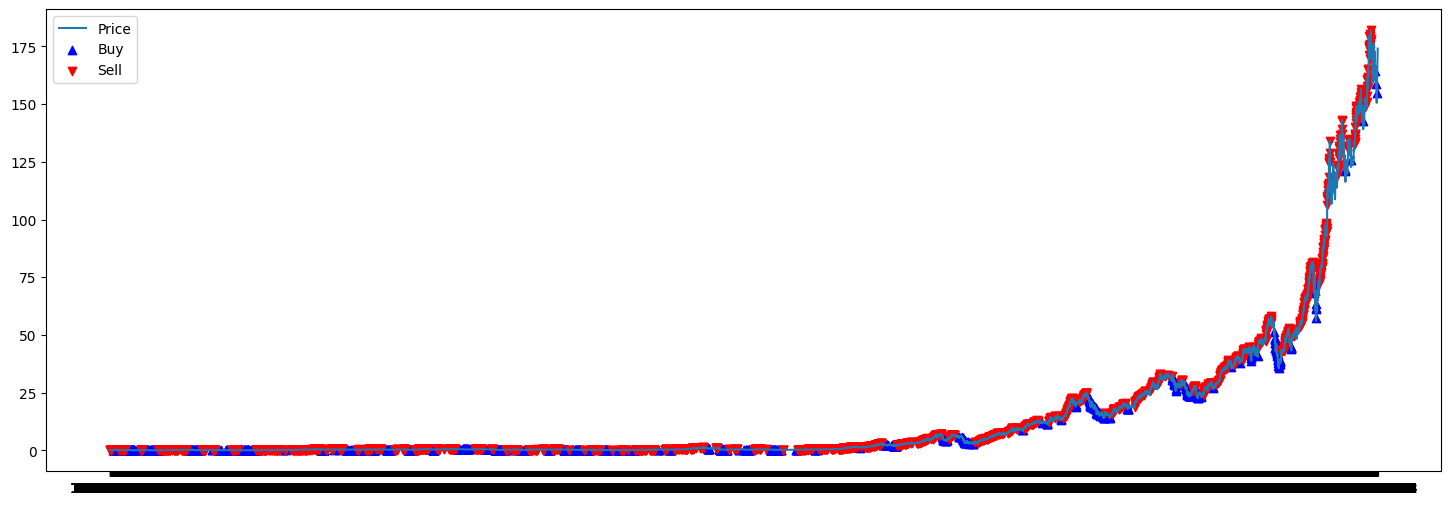

In [110]:
# KELTNER CHANNELS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create the binary labels (1: buy, 0: sell)
kcsignal = np.where(df['Close'].shift(-1) > df['kc_upper'].shift(-1), 0,
                        np.where(df['Close'].shift(-1) < df['kc_lower'].shift(-1), 1, np.nan))

df.tail()
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['kc_middle'][:-1], df['label'][:-1], test_size=0.3)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train.values.reshape(-1, 1), y_train)

# Predict labels for testing set
y_pred = model.predict(X_test.values.reshape(-1, 1))

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create a plot of the Keltner Channels indicator and the buy/sell signals
plt.figure(figsize=(18, 6))
plt.plot(df['Close'], label='Price')
plt.scatter(df[kcsignal == 1].index, df[kcsignal == 1]['Close'], marker='^', color='blue', label='Buy')
plt.scatter(df[kcsignal == 0].index, df[kcsignal == 0]['Close'], marker='v', color='red', label='Sell')
plt.legend()
plt.show()

Accuracy: 0.531592520954223


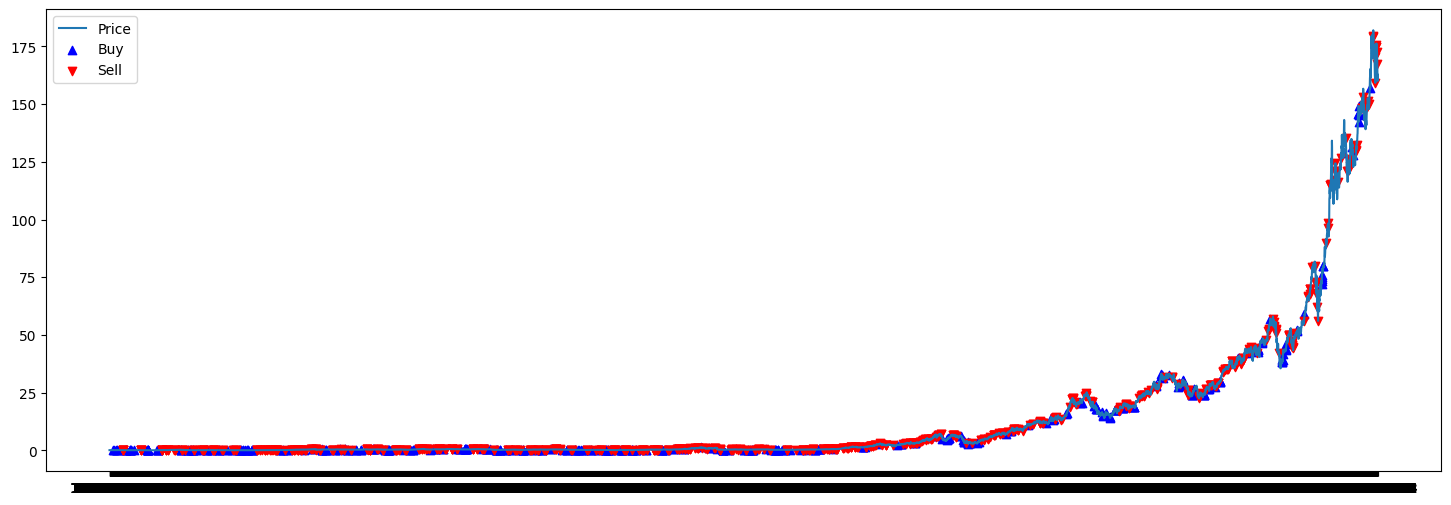

In [111]:
# BOLLINGER BANDS

# Create the binary labels (1: buy, 0: sell)
bbsignal = np.where(df['Close'].shift(-1) > df['BB_upperband'].shift(-1), 0,
                        np.where(df['Close'].shift(-1) < df['BB_lowerband'].shift(-1), 1, np.nan))                       
features = ['BB_upperband', 'BB_lowerband', 'SMA']
df = df.dropna()
bbsignal = bbsignal[:len(df['Close'])] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features][:-1], df['label'][:-1], test_size=0.3)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train.values.reshape(-1, len(features)), y_train)

# Predict labels for testing set
y_pred = model.predict(X_test.values.reshape(-1, len(features)))

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create a plot of the Bollinger Bands indicator and the buy/sell signals
plt.figure(figsize=(18, 6))
plt.plot(df['Close'], label='Price')
plt.scatter(df[bbsignal == 1].index, df[bbsignal == 1]['Close'], marker='^', color='blue', label='Buy')
plt.scatter(df[bbsignal == 0].index, df[bbsignal == 0]['Close'], marker='v', color='red', label='Sell')
plt.legend()
plt.show()



Accuracy: 0.5064474532559639


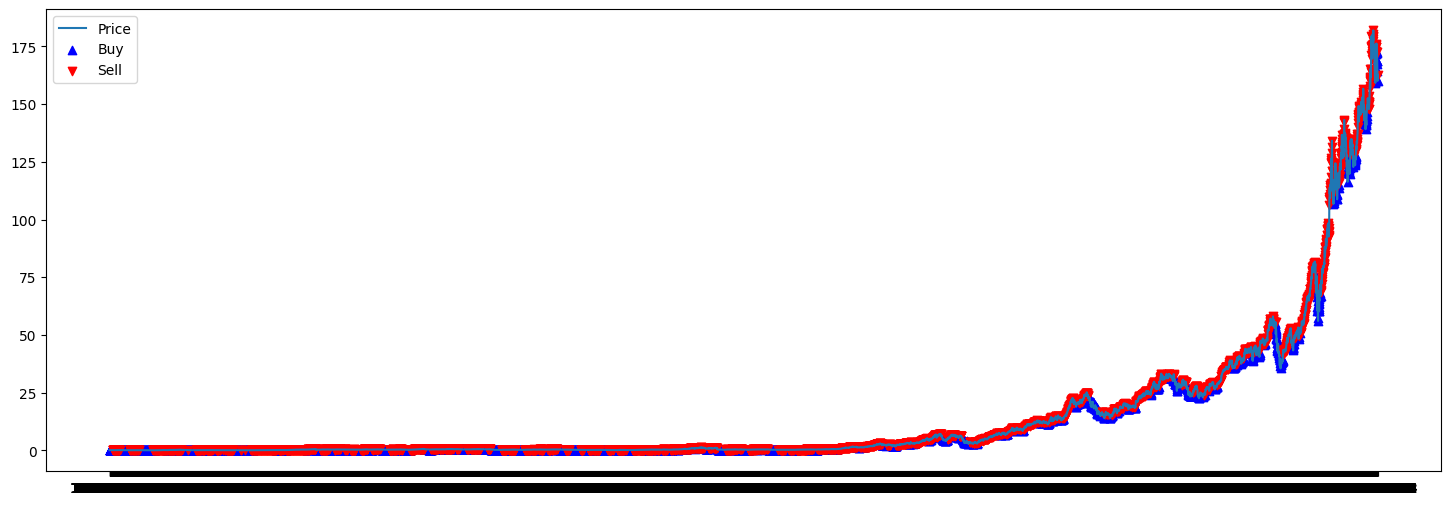

In [112]:
# MOVING AVERAGE

# Create the binary labels (1: buy, 0: sell)
masignal = np.where(df['MA'].shift(-1) > df['Close'], 1, 0)
df = df.dropna()
masignal = masignal[:len(df['Close'])]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['MA'][:-1], df['label'][:-1], test_size=0.3)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train.values.reshape(-1, 1), y_train)

# Predict labels for testing set
y_pred = model.predict(X_test.values.reshape(-1, 1))

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create a plot of the Moving Average indicator and the buy/sell signals
plt.figure(figsize=(18, 6))
plt.plot(df['Close'], label='Price')
plt.scatter(df[masignal == 1].index, df[masignal == 1]['Close'], marker='^', color='blue', label='Buy')
plt.scatter(df[masignal == 0].index, df[masignal == 0]['Close'], marker='v', color='red', label='Sell')
plt.legend()
plt.show()

Accuracy: 0.562862669245648


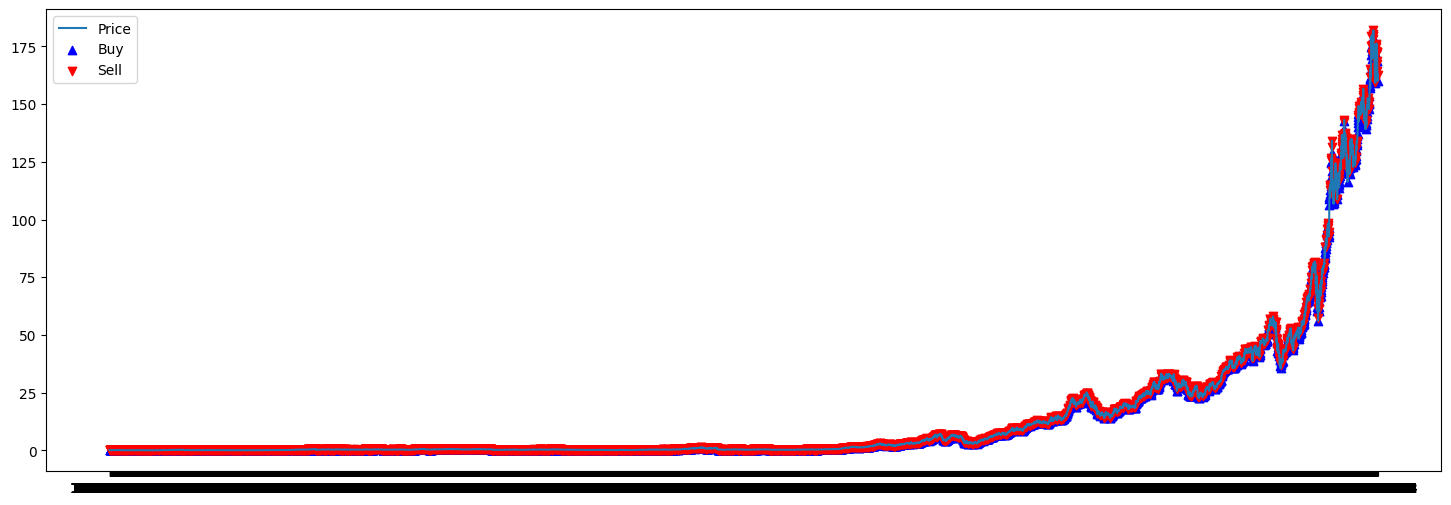

In [113]:
# Heads and Shoulders
# Calculate the neckline (a line connecting the lows of the two shoulders)
df["Neckline"] = (df["left_shoulder"] + df["right_shoulder"]) / 2

# Above neckline you sell, (0), below neckline you buy (1)
hssignal = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
features = ["left_shoulder", "right_shoulder"]
df = df.dropna()
hssignal = hssignal[:len(df['Close'])]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features][:-1], df['label'][:-1], test_size=0.3)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict labels for testing set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create a plot of the Moving Average indicator and the buy/sell signals
plt.figure(figsize=(18, 6))
plt.plot(df['Close'], label='Price')
plt.scatter(df[hssignal == 1].index, df[hssignal == 1]['Close'], marker='^', color='blue', label='Buy')
plt.scatter(df[hssignal == 0].index, df[hssignal == 0]['Close'], marker='v', color='red', label='Sell')
plt.legend()
plt.show()


Accuracy: 0.5080593165699548


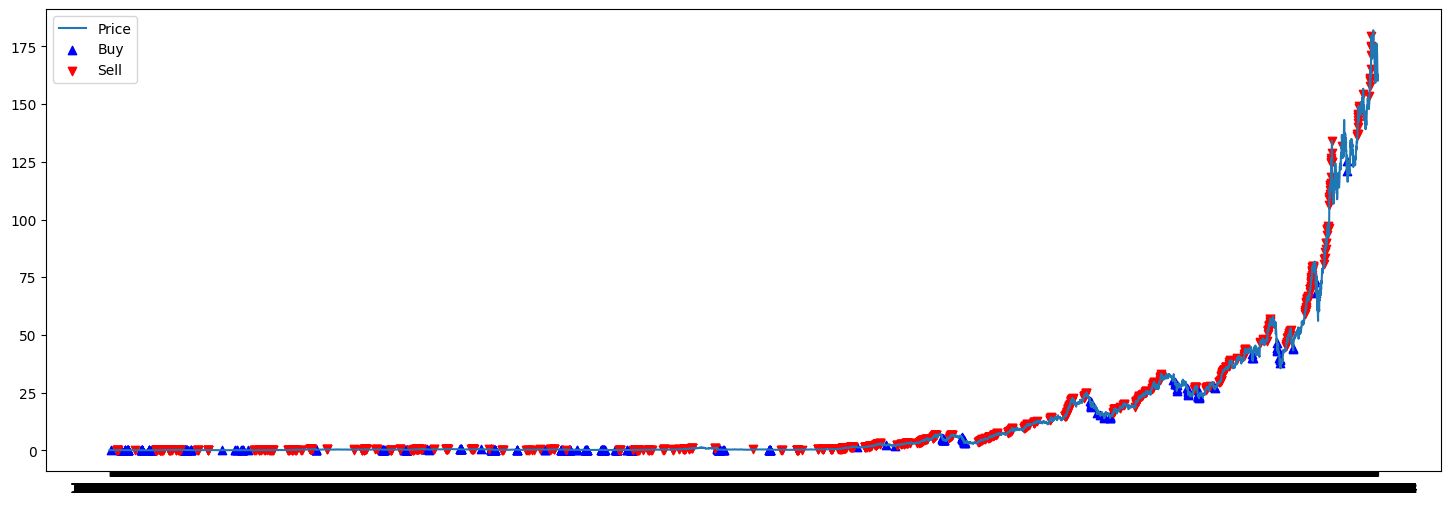

In [114]:
# RSI
# Create the binary labels (1: buy, 0: sell)
rsisignal = np.where(df["RSI"].shift(-1) > 70, 0, np.where(df["RSI"].shift(-1) < 30, 1, -1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['RSI'][:-1], df['label'][:-1], test_size=0.3)
rsisignal = rsisignal[:len(df['Close'])]
# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train.values.reshape(-1, 1), y_train)

# Predict labels for testing set
y_pred = model.predict(X_test.values.reshape(-1, 1))

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create a plot of the Moving Average indicator and the buy/sell signals
plt.figure(figsize=(18, 6))
plt.plot(df['Close'], label='Price')
plt.scatter(df[rsisignal == 1].index, df[rsisignal == 1]['Close'], marker='^', color='blue', label='Buy')
plt.scatter(df[rsisignal == 0].index, df[rsisignal == 0]['Close'], marker='v', color='red', label='Sell')
plt.legend()
plt.show()

### Logistic Regression for ALL indicators

In [115]:
features = ['MA', 'RSI', 'kc_middle', 'kc_upper', 'kc_lower', 'BB_upperband', 'SMA', 'BB_lowerband', 'left_shoulder', 'right_shoulder', 'head_shoulders']

X_train, X_test, y_train, y_test = train_test_split(df[features], df["label"], test_size=0.3)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict labels for testing set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5460992907801419


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [116]:
df.shape

(10340, 23)